In [1]:
from src.analysis import get_best_results, read_results_file, plot_experiments, create_radar_chart
import pandas as pd
import plotly.io as pio
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [12]:
data = pd.read_csv("data/processed/airpollution/data.csv")
data_cropped = data[data.year>=2019].reset_index(drop=True)

data_cropped = data_cropped.rolling(window=24).mean()


In [ ]:
fig = make_subplots()
for col in [c for c in data_cropped.columns if 'NO' in c]:
    fig.add_trace(
        go.Scatter(x = pd.date_range("2019-01-01", "2022-03-17", freq="h"), y=data_cropped[col], name=col),
    )

fig.layout.hovermode = 'x unified'
fig.show()

In [ ]:
fig = make_subplots()
for col in [c for c in data_cropped.columns if 'NO' in c]:
    fig.add_trace(
        go.Scatter(x = pd.date_range("2019-01-01", "2022-03-17", freq="h"), y=data_cropped[col], name=col),
    )

fig.layout.hovermode = 'x unified'
fig.show()

In [2]:
total_metrics = read_results_file("results/airpollution/results_test.csv")
total_metrics = total_metrics[total_metrics.model_name!='linear']

In [3]:
groupby_columns = ['dataset_name', 'model_name']
selected_columns = ['rmse', "mse", "mae", "wape", "mase", "mape", "duration", 'n_features', 'dataset_params_seq_len']

In [4]:
best_results = get_best_results(total_metrics)
best_results_by_model = best_results.groupby(groupby_columns, dropna=False)[selected_columns].mean().reset_index().pivot(index = 'model_name', columns='dataset_name', values=['mae', 'mse', 'rmse', 'wape', 'duration']).round(3)#.to_latex('tables/efficacy.tex')
best_results_by_model

,mae,mse,rmse,wape,duration
dataset_name,airpollution,airpollution,airpollution,airpollution,airpollution
model_name,,,,,
DT,11.942,357.718,18.769,0.483,31.176
FF,15.191,497.103,22.254,0.583,18.424
L1,12.149,506.006,21.242,0.495,2169.395
LSTM,12.530,384.880,19.603,0.477,9.156
knn,12.472,380.953,19.118,0.497,0.007
rf,11.008,292.894,16.993,0.444,2317.936


In [5]:
#best_results_by_model.columns = ["model_name", "mae", "mse", "rmse", "wape"]
best_results_by_model.stack().reset_index()

C:\Users\User\AppData\Local\Temp\ipykernel_23704\4100982817.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  best_results_by_model.stack().reset_index()


,model_name,dataset_name,mae,mse,rmse,wape,duration
0,DT,airpollution,11.942,357.718,18.769,0.483,31.176
1,FF,airpollution,15.191,497.103,22.254,0.583,18.424
2,L1,airpollution,12.149,506.006,21.242,0.495,2169.395
3,LSTM,airpollution,12.530,384.880,19.603,0.477,9.156
4,knn,airpollution,12.472,380.953,19.118,0.497,0.007
5,rf,airpollution,11.008,292.894,16.993,0.444,2317.936


C:\Users\User\AppData\Local\Temp\ipykernel_23704\4254889934.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  create_radar_chart(best_results_by_model.stack().reset_index(), name_col="model_name", categories=["mae", "rmse", "mse", "wape", "duration"])


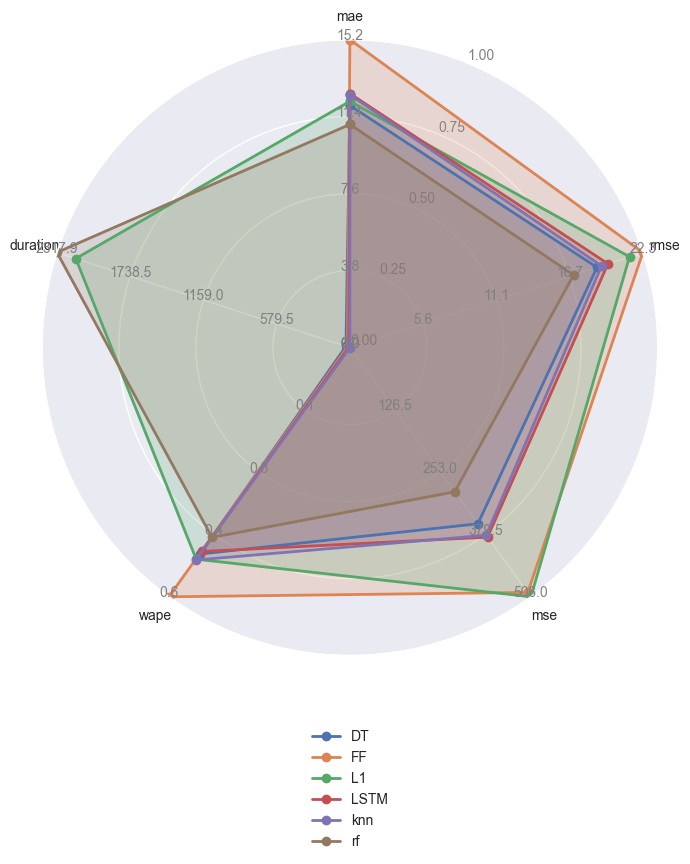

In [6]:
create_radar_chart(best_results_by_model.stack().reset_index(), name_col="model_name", categories=["mae", "rmse", "mse", "wape", "duration"])

In [7]:
groupby_columns = ['dataset_name', 'model_name', 'dataset_params_test_year']

best_results.groupby(groupby_columns, dropna=False)[selected_columns].mean().reset_index().pivot(index = ['dataset_params_test_year'], columns=["dataset_name", 'model_name'], values=['rmse']).round(1)#.to_latex('tables/efficacy_by_year.tex')

rmse                              
dataset_name             airpollution                              
model_name                         DT    FF    L1  LSTM   knn    rf
dataset_params_test_year                                           
2019                             18.5   NaN  15.1   NaN  17.6  16.1
2020                             17.1   NaN  16.0   NaN  16.7  15.6
2021                             16.8  20.9  33.6  18.8  16.2  15.8
2022                             22.6  23.6  20.3  20.4  25.9  20.5

<Figure size 2000x2000 with 0 Axes>

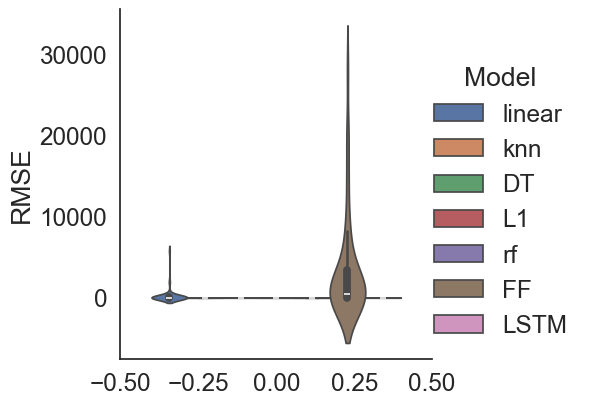

In [12]:
plot_experiments(total_metrics, kind='violin')

<Figure size 2000x2000 with 0 Axes>

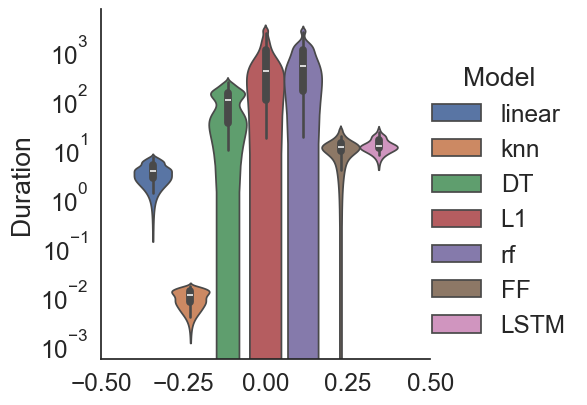

In [13]:
plot_experiments(total_metrics, y='Duration', kind='violin', yscale='log')

<Figure size 2000x2000 with 0 Axes>

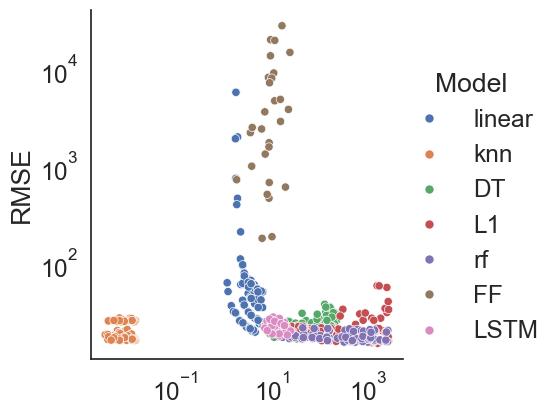

In [14]:
plot_experiments(total_metrics, plot_type='rel', kind='scatter', y='RMSE', x="Duration", yscale='log', xscale='log')

## Individual analysis

In [ ]:
best_codes_by_model = best_results.groupby(groupby_columns).head(1)["code"].tolist()
best_codes_by_model

## Selection masks

In [10]:
from itertools import product
import numpy as np

def get_mask_df(selection_masks, features_list, maximum_seq_len, dataset, levels):
    mask_dict = {}
    lags = np.array([f't-{t}'for t in range (maximum_seq_len, 0, -1)])

    mask_dict["layer_level"] = selection_masks.flatten().tolist()

    feats_lags = list(product(features_list, lags))

    mask_dict["features"] = [fl[0] for fl in feats_lags]
    mask_dict["lags"] = [fl[1] for fl in feats_lags]

    df_mask = pd.DataFrame(mask_dict)

    df_mask["dataset"] = dataset

    df_mask["layer"] = df_mask["layer_level"].map(lambda l: levels[int(l)])

    return df_mask

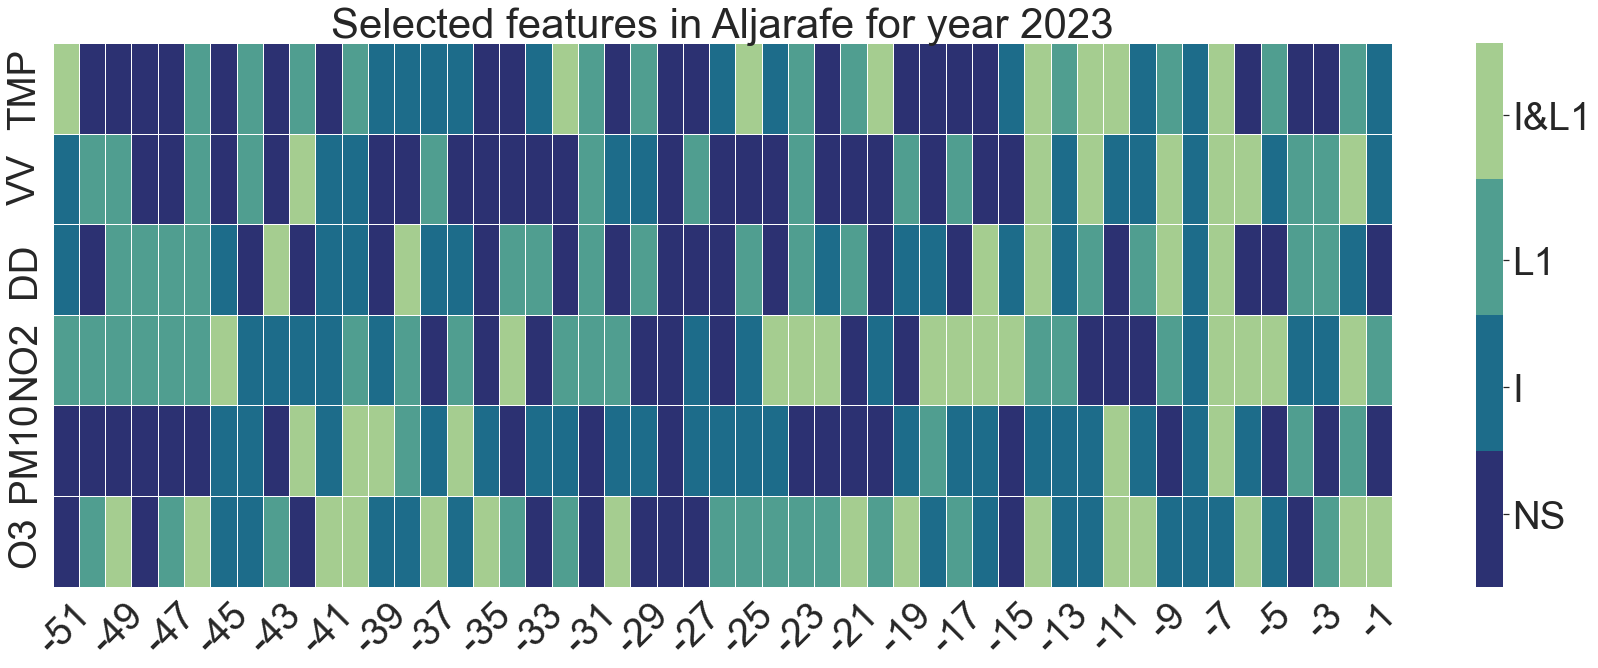

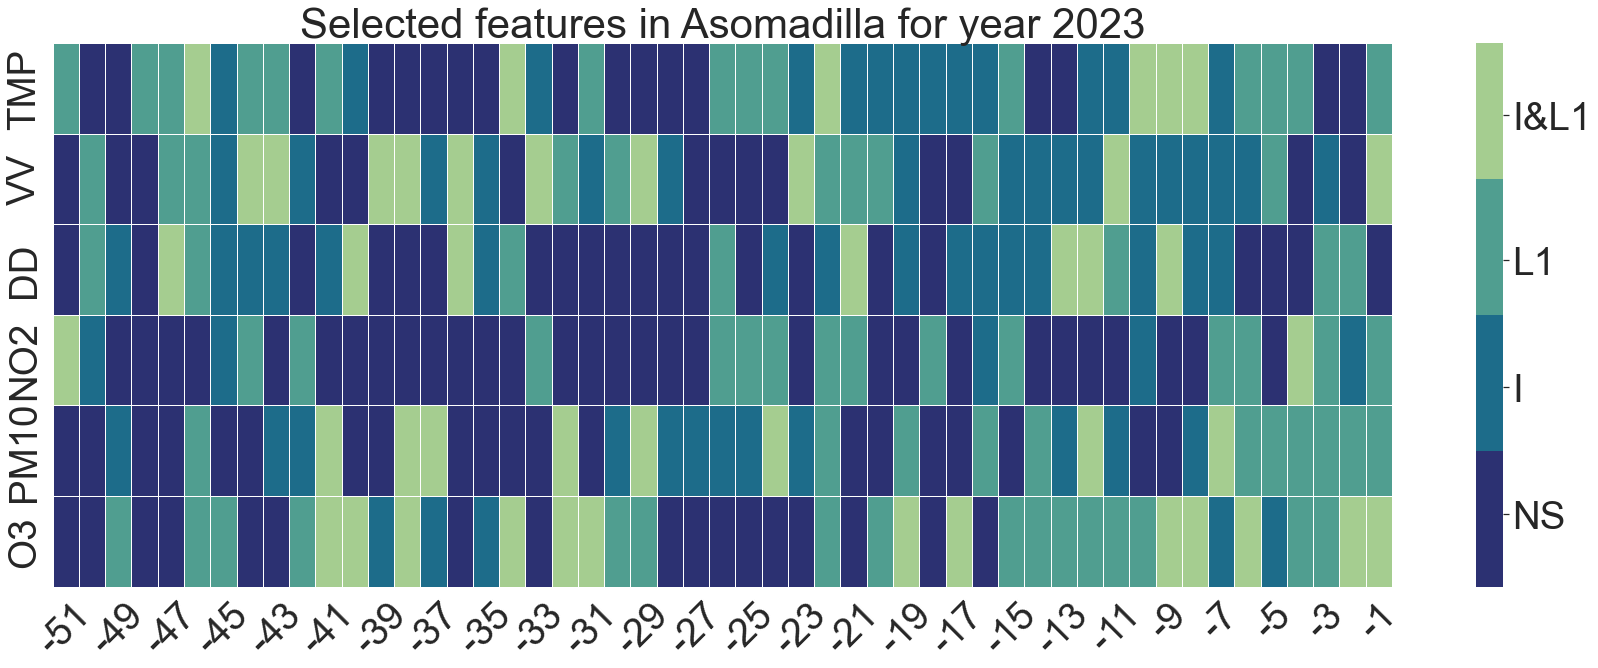

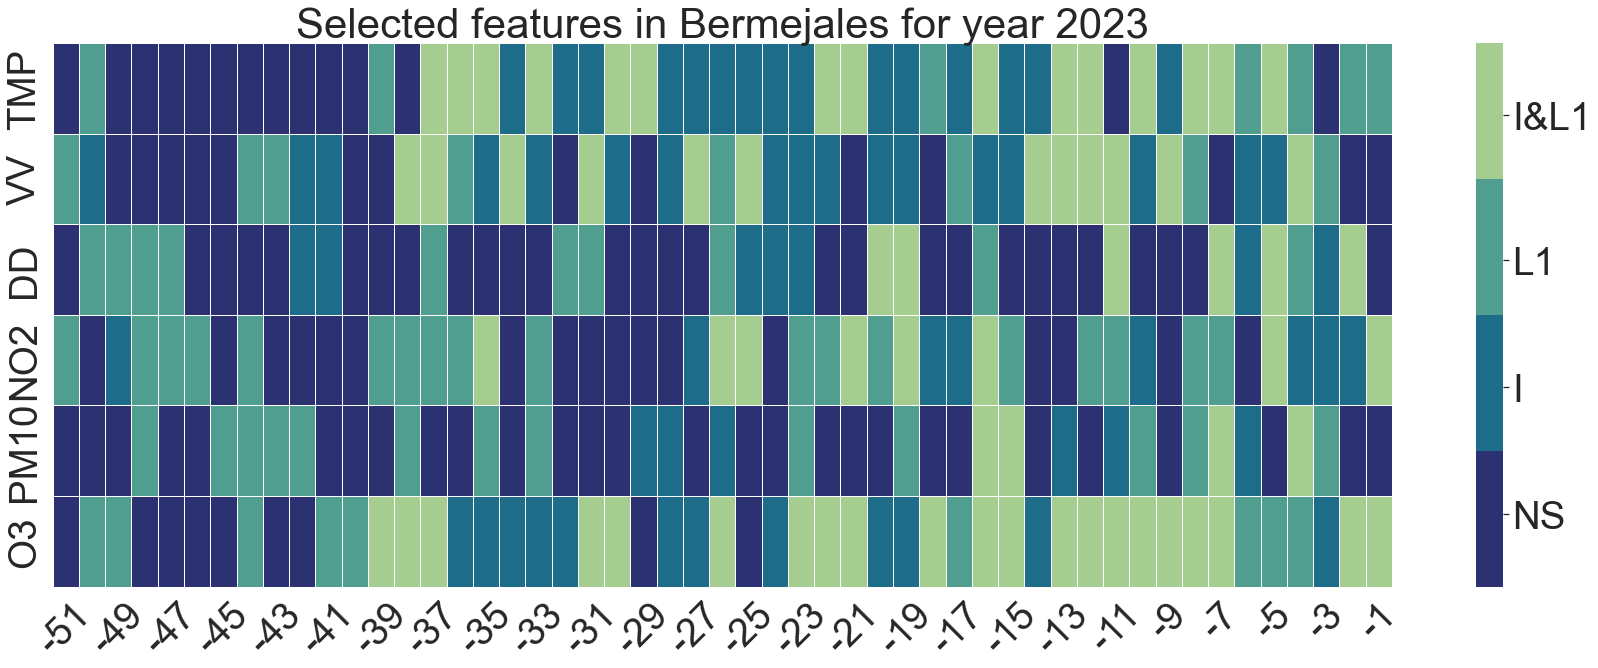

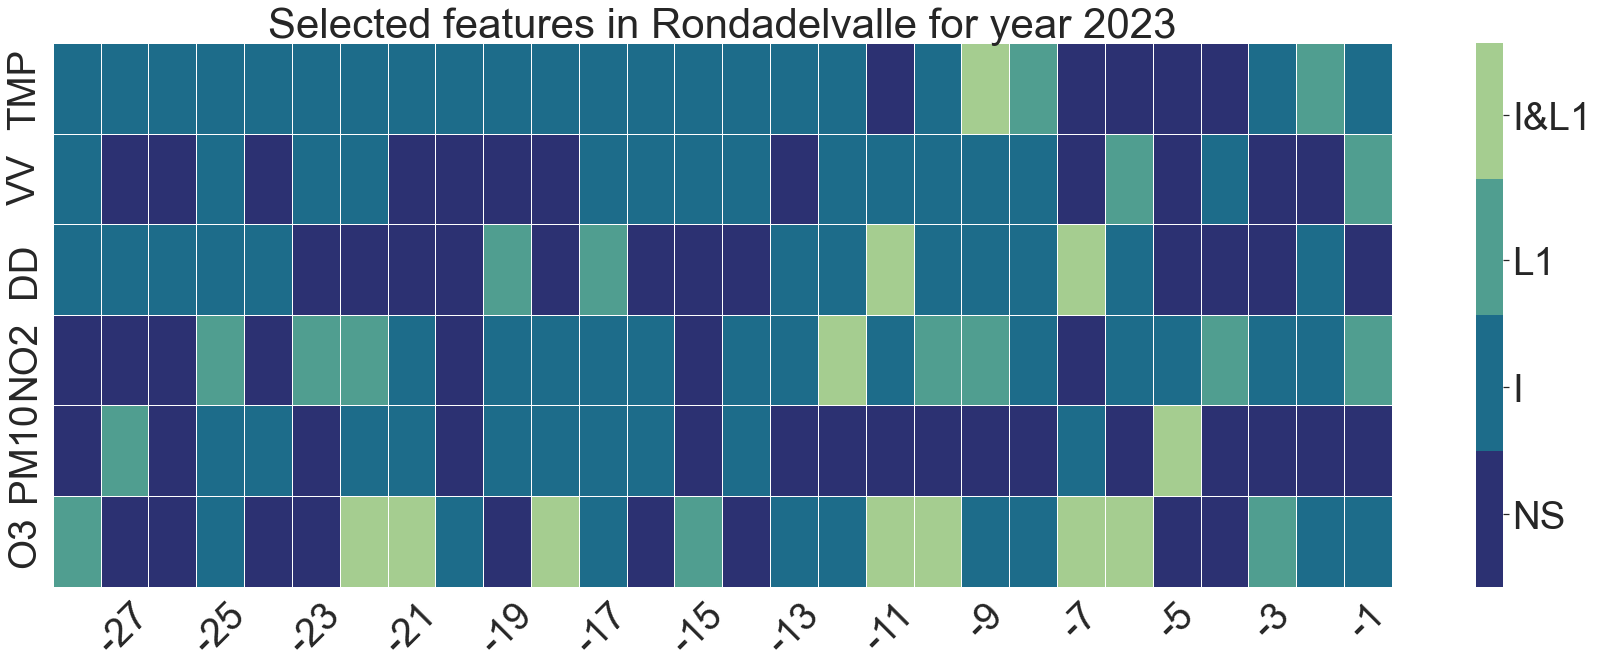

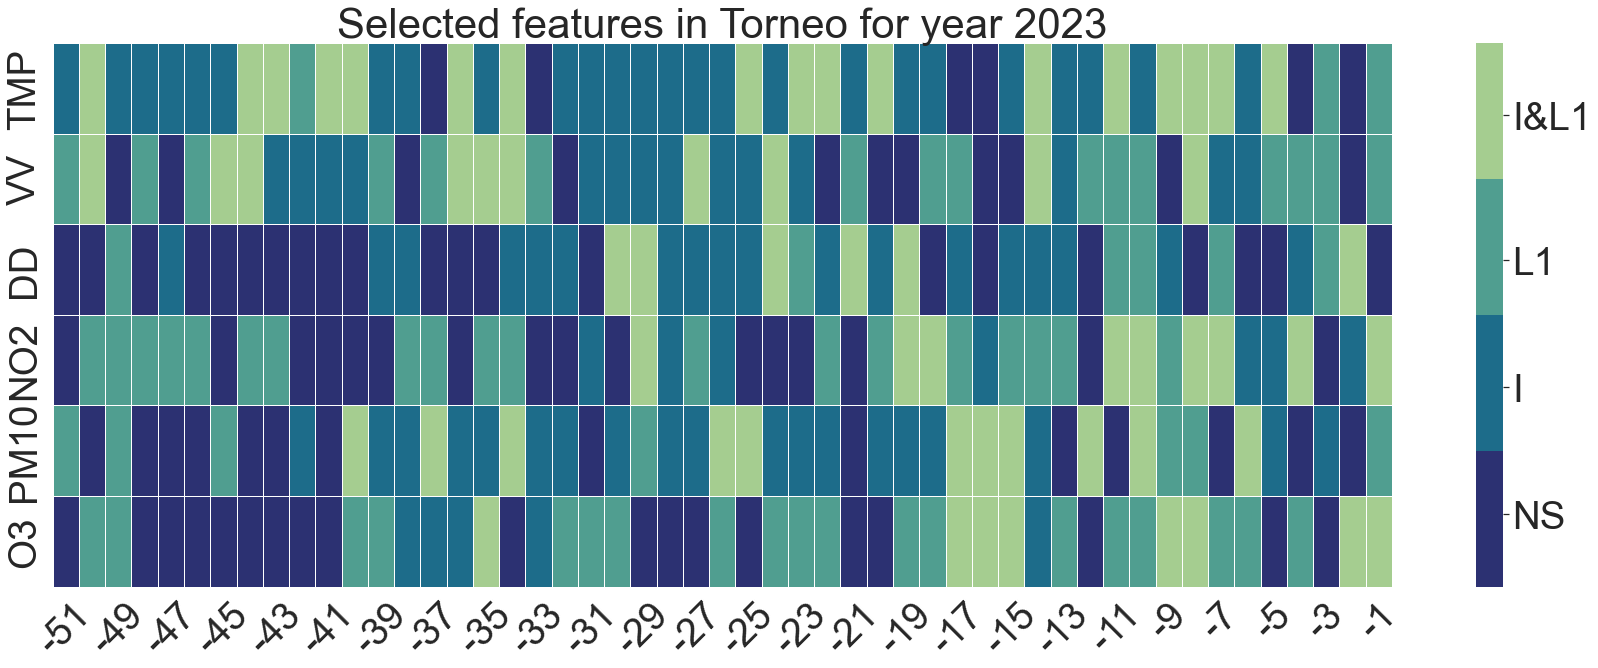

In [37]:
sns.set(font_scale=3.5)
import numpy as np
from matplotlib.colors import ListedColormap

model_name = 'LSTM*'

df_mask = pd.DataFrame()

features_list = ['tmp', 'vv', 'dd', 'no2', 'pm10', 'target_o3']#['tmp', 'vv', 'dd', 'no2', 'pm10', 'o3']
for dataset in best_results.dataset.unique():
    results_tsl_dataset = best_results[(best_results.dataset==dataset) & (best_results.model_name==model_name)].sort_values('dataset_params_test_year')
    results_tsl_dataset_2023 = results_tsl_dataset.loc[best_results['dataset_params_test_year']==2023]
    selected_features = results_tsl_dataset_2023.selected_features.apply(eval).iloc[0]

    selection_masks = []

    seq_lens = []
    for level, mask in selected_features.items():
        seq_lens.extend([int(name.split('t-')[1]) for name in mask])
    maximum_seq_len = max(seq_lens)

    level_score = [0, 1, 3, 5]
    
    for feat in features_list:
        
        mask_by_level = np.zeros((maximum_seq_len,))
        for i, (level, mask) in enumerate(selected_features.items()):
            
            mask = np.array(mask)
            feats = np.array([f'{feat} t-{t}'for t in range (maximum_seq_len, 0, -1)])

            sfeats = mask[np.core.defchararray.find(mask, feat)!=-1]

            mask_selected = np.isin(feats, sfeats).astype(np.uint)
            mask_selected[mask_selected>0] += level_score[i]
            mask_by_level += mask_selected

        selection_masks.append(mask_by_level)
    
    selection_masks = np.stack(selection_masks)
    fig, ax = plt.subplots(figsize=(30,10))

    dataset.replace("Rondadelvalle", "Ronda del valle")
    ax.set_title(f'Selected features in {dataset[:-4]} for year 2023')

    number_of_levels = int(np.max(selection_masks))

    cmap_crest = sns.cm.crest_r
    cmap = ListedColormap(cmap_crest.colors[::(len(cmap_crest.colors)-1)//(number_of_levels)])

    
    feats[-2::-2] = ''
    xticks = list(map(lambda f: f.replace('target_o3 t', ''), feats.tolist()))
    g = sns.heatmap(selection_masks, yticklabels=list(map(lambda x: x.upper(), ['tmp', 'vv', 'dd', 'no2', 'pm10', 'o3'])),cmap=cmap, xticklabels=xticks, linewidth=.5, ax=ax)
    plt.xticks(rotation=45)

    colorbar = g.collections[0].colorbar

    if 8>=number_of_levels>4:
        positions = np.array([0.4, 1.3, 2.2, 3.1, 4, 4.8, 5.7, 6.6, 7.5])
    elif number_of_levels>8:
        positions = np.array([0.4, 1.3, 2.2, 3.1, 4.2, 5, 5.9, 7, 7.8, 8.8, 9.7, 10.7, 11.5, 12.5])
    else:
        positions = np.array([0.4, 1.1, 1.8, 2.6, 3.2, 3.9, 4.6, 5.1, 5.8])

    levels = np.array(['NS', 'I', 'L1', "I&L1", "L2", "I&L2", "L1&L2", "I&L1&L2", "L3", "I&L3", "L1&L3", "L2&L3", "I&L1&L3", "I&L1&L2&L3"])
    #colorbar.set_ticks(positions[:number_of_levels+1])
    colorbar.set_ticks(positions[:number_of_levels+1])
    colorbar.set_ticklabels(levels[:number_of_levels+1])

    fig = g.get_figure()

    fig.savefig(f"figures/SelectionMasks/Ozone_{dataset}.png", bbox_inches='tight') 

    df_mask = pd.concat((df_mask, get_mask_df(selection_masks, features_list, maximum_seq_len, dataset, levels)))
    

In [12]:
df_mask["dataset"] = df_mask["dataset"].str[:-4]
df_mask

,layer_level,features,lags,dataset,layer
0,3.0,tmp,t-51,Aljarafe,I&L1
1,0.0,tmp,t-50,Aljarafe,NS
2,0.0,tmp,t-49,Aljarafe,NS
3,0.0,tmp,t-48,Aljarafe,NS
4,0.0,tmp,t-47,Aljarafe,NS
...,...,...,...,...,...
301,0.0,target_o3,t-5,Torneo,NS
302,2.0,target_o3,t-4,Torneo,L1
303,0.0,target_o3,t-3,Torneo,NS
304,3.0,target_o3,t-2,Torneo,I&L1


<Figure size 1440x1440 with 0 Axes>

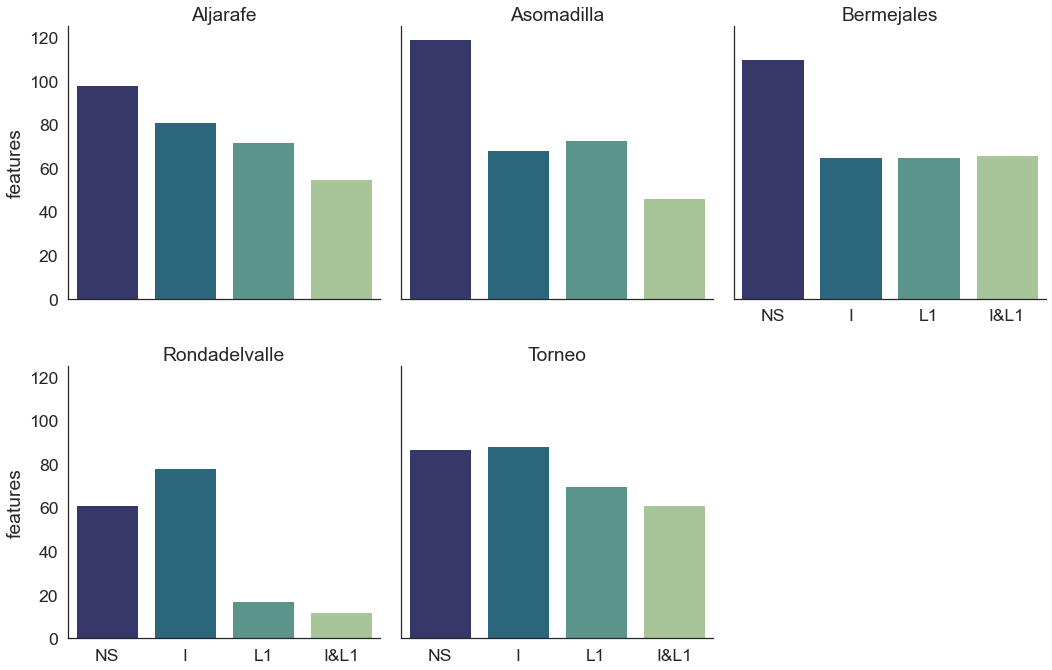

In [13]:
sns.set(font_scale=1.6, style='white')
plt.figure(figsize=(20,20))
import matplotlib


g = sns.catplot(data=df_mask.groupby(["dataset", "layer"]).count().reset_index(), kind='bar', x='layer', y="features", col='dataset', order=levels[:number_of_levels+1], palette=[matplotlib.colors.rgb2hex(c)for c in cmap.colors], col_wrap=3)#.set_yscale("log")
g.set(xlabel=None)
g.set_titles(template="{col_name}")
plt.savefig('figures/barplot_features.png')
plt.show()
plt.show()

<Figure size 1440x1440 with 0 Axes>

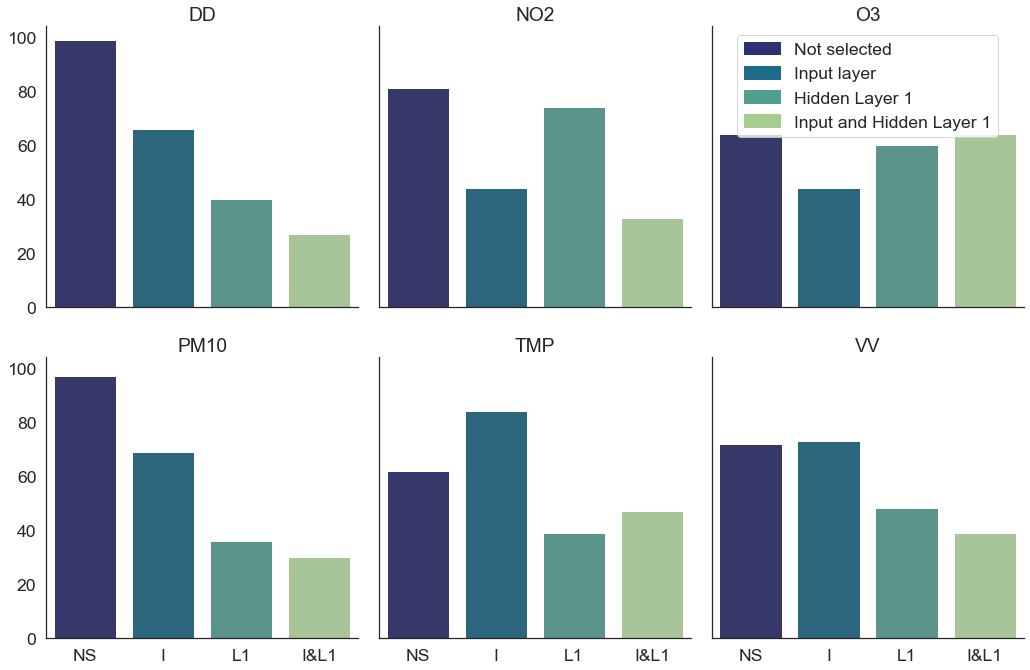

In [36]:
sns.set(font_scale=1.6, style='white')
plt.figure(figsize=(20,20))
import matplotlib
import matplotlib.patches as mpatches
patch_ns = mpatches.Patch(color=cmap.colors[0], label='Not selected')
patch_i = mpatches.Patch(color=cmap.colors[1], label='Input layer')
patch_l1 = mpatches.Patch(color=cmap.colors[2], label='Hidden Layer 1')
patch_i_l1 = mpatches.Patch(color=cmap.colors[3], label='Input and Hidden Layer 1')

handles = [patch_ns, patch_i, patch_l1, patch_i_l1]

df_mask["features"] = df_mask["features"].str.upper().str.replace("TARGET_", '')

g = sns.catplot(data=df_mask.groupby(["layer", "features"]).count().reset_index(), kind='bar', x='layer', y="dataset", col='features', order=levels[:number_of_levels+1], palette=[matplotlib.colors.rgb2hex(c)for c in cmap.colors], col_wrap=3)#.set_yscale("log")
g.set(xlabel=None, ylabel=None)
g.set_titles(template="{col_name}")

g.axes[2].legend(handles=handles, loc='upper center')


plt.savefig('figures/barplot_features_by_layer.png')
plt.show()
plt.show()

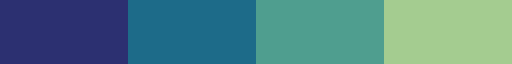

In [18]:
cmap

## Bayesian tests

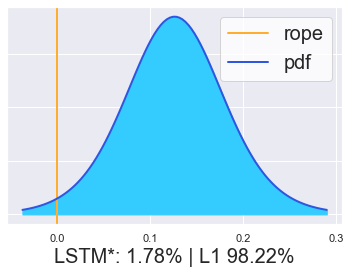

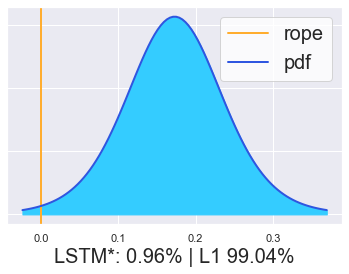

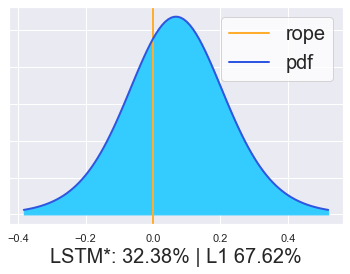

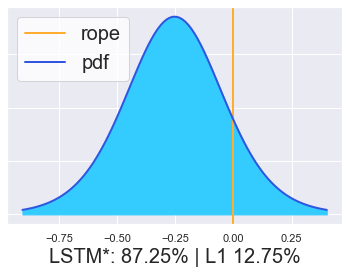

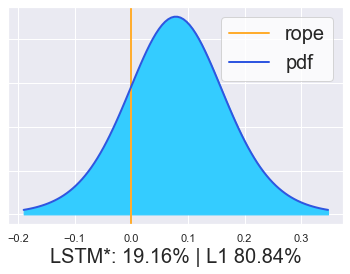

In [52]:
from baycomp import two_on_single
import matplotlib

import matplotlib.pyplot as plt



for dataset in best_results.dataset.unique():
    metrics_tsl = best_results[(best_results.dataset==dataset) & (best_results.model_name=='LSTM*')].rmse.values
    metrics_l1 = best_results[(best_results.dataset==dataset) & (best_results.model_name=='L1')].rmse.values
    probs, fig = two_on_single(metrics_tsl, metrics_l1, names=['LSTM*', 'L1'], plot=True)
    plt.xlabel(f'LSTM*: {round(probs[0]*100, 2)}% | L1 {round(probs[1]*100, 2)}%', fontsize=20)
    plt.legend(fontsize=20)
    fig.savefig(f"figures/Baytest/Baytest{dataset}.png", bbox_inches='tight') 

    

## Best hyperparameters

In [ ]:
best_hyperparameters = best_results.groupby(["dataset", "model_name"]).head(1).reset_index().copy()

In [ ]:
import numpy as np
pd.set_option('display.max_colwidth', 2000)
params = list(map(lambda my_dict: {k: round(my_dict[k], 4) if not my_dict[k].is_integer() else int(my_dict[k]) for k in my_dict if not np.isnan(my_dict[k])},best_hyperparameters.loc[:, ['model_params_layers', 'model_params_units', 'model_params_batch_size', 'model_params_lr','model_params_dropout',  'model_params_max_depth', 'model_params_alpha','selection_params_regularization']].to_dict('records')))
best_hyperparameters['window'] = best_hyperparameters.dataset_params_seq_len #
best_hyperparameters['params'] = params

best_hyperparameters[["dataset", "model_name", "window", "params", "dataset_params_seq_len"]].set_index(['dataset', 'model_name', 'window']).to_latex('tab.tex')

In [ ]:
best_hyperparameters.to_csv("results/ResSelNet/params/best_params.csv")